# Objective:

We try to look at credit data for a large number of people. We try to analyze the data and see correlations between 'Serious Delinquencies' and other relevant credit information of a person.






# Dataset used:

The dataset used was from a Kaggle competition called 'Give me Some Credit'. The original dataset can be found from: https://www.kaggle.com/c/GiveMeSomeCredit/data.

## 1. Python packages and libraries


In [1]:
import torch, pandas as pd, numpy as np, seaborn as sns, itertools
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, RocCurveDisplay, make_scorer
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV
from itertools import combinations, chain
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 2. Dataset importing

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/tanujmath/CreditGuard/main/data/cs-training-new.csv')
print(f"The shape of the data is {df.shape}") #prints the shape of the data
df.head()

The shape of the data is (120218, 10)


,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,NumberOfTimeLate
0,1,1,0.766127,45,0.802982,9120.0,13,6,2.0,0.333333
1,2,0,0.957151,40,0.121876,2600.0,4,0,1.0,0.000000
2,3,0,0.658180,38,0.085113,3042.0,2,0,0.0,0.666667
3,4,0,0.233810,30,0.036050,3300.0,5,0,0.0,0.000000
4,5,0,0.907239,49,0.024926,63588.0,7,1,0.0,0.166667


## 3. Best Fit model : XGBoost

### 3a. creating train-test split of the data

In [3]:
# train-test split

# first we make a deep copy of the engineered data

# first make a deep copy of the data
df2=df.copy(deep=True)
# standardization of columns (subtract mean and divide by variance)

## Make a scaler object : i.e. the StandardScaler object below which will know what to do make the standardization in the way we want
scaler=StandardScaler()

## fit the scaler : calling 'fit' means, the case of standardizing here, knowing the columns and the mean, standard deviation of the each of the columns
scaler.fit(df2)

#let us see the new dataset
df2.head()

# scaling the data
df_scale =scaler.transform(df2)

# creating an array with the scaled regression quantities we care about:

X=df_scale[:,[2,4,5,6,7,8,9]]

y=df2['SeriousDlqin2yrs']

# creating train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=14,
                                   test_size=0.2,
                                   shuffle=True)

### 3b. Running XGBoost

In [4]:
# Define the model. If GPU is present, use GPU.
model = XGBClassifier(tree_method='hist', device = 'cuda')

# Define the parameters for the RandomizedSearch
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

#Initialize randomized search
random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=5,
                                   scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Make predictions
y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)[:, 1]

# Evaluate the model
auc = roc_auc_score(y_test, y_pred_proba)

print(f"AUC: {auc}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
AUC: 0.8419843934421216


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:38:33] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


## 4. Personalized suggestion of 3 features

### 4a. Finding a threshold to identify the people with high risk of delinquency

In [5]:
xg3=XGBClassifier(tree_method='hist', device = 'cuda')
xg3.fit(X_train,y_train)
delinquent_index = []
y_pred=xg3.predict_proba(X_test)


In [6]:
val = 0
t = 0.1
while(t<1):
  y_pred_binary = [1 if y_pred[i][0]<t else 0 for i in range(len(y_pred))]
  conf_mat = confusion_matrix(y_test, y_pred_binary)
  yay = conf_mat[0][0] + conf_mat[1][1]
  if yay>val:
    val = yay
    thresh = t
  t+=0.1
print(thresh)

0.4


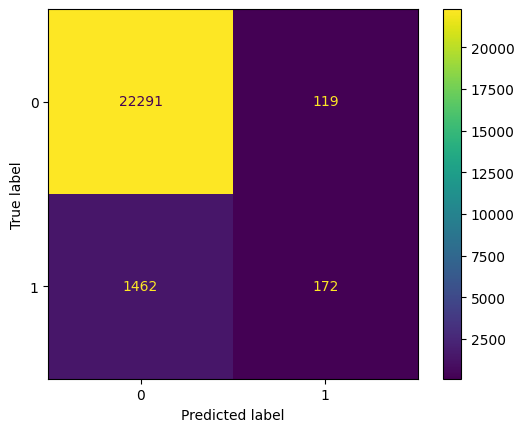

In [7]:
y_pred_binary = [1 if y_pred[i][0]<0.4 else 0 for i in range(len(y_pred))]
conf_mat = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=xg3.classes_)
disp.plot()
plt.show()

### 4b. Identifying people with high risk of delinquency and suggesting 3 most important features for them to improve upon

In [8]:
print("Features of Interest:\n 2 = RevolvingUtilizationOfUnsecuredLines;\n  4 = DebtRatio;\n  5 = MonthlyIncome;\n  6 = NumberOfOpenCreditLinesAndLoans;\n  7 = NumberRealEstateLoansOrLines;\n 9 = NumberOfTimeLate")
print(" ")

for i in range(len(y_pred)):
  if y_pred[i][1] >= thresh:
    delinquent_index.append(i)

print(len(delinquent_index))
print("Delinquent Index: People from test data prone to delinquency based on XGBoost")
print(delinquent_index)
print(" ")


comb = combinations([2, 4, 5, 6, 7, 9], 3)

j=[]
k=[]
person = input('Enter the index corresponding to the likely delinquent person from the delinquent_index array: ')
person = int(person)

for i in comb:
  X_subset=df_scale[:,[i[0],i[1],i[2]]]
  reg_temp = XGBClassifier(tree_method='hist', device = 'cuda')
  X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset,y,
                                    random_state=14,
                                    test_size=0.2,
                                    shuffle=True)
  reg_temp.fit(X_train_subset,y_train_subset)
  #print((reg_temp.predict_proba(X_subset)[person] ) )
  j.append((reg_temp.predict_proba(X_test_subset)[person])[1])
  k.append(i)


print(" ")
print(f"Person {person} is likely to default as predicted delinquency score of {np.max(np.array(j))} is greater than {thresh}")
print(f"Person {person} can reduce chances of serious delinquency by taking care of the features: {np.array(k)[np.argmax(np.array(j))]}")

Features of Interest:
 2 = RevolvingUtilizationOfUnsecuredLines;
  4 = DebtRatio;
  5 = MonthlyIncome;
  6 = NumberOfOpenCreditLinesAndLoans;
  7 = NumberRealEstateLoansOrLines;
 9 = NumberOfTimeLate
 
865
Delinquent Index: People from test data prone to delinquency based on XGBoost
[0, 54, 66, 76, 91, 110, 111, 117, 123, 125, 136, 177, 184, 206, 224, 259, 278, 279, 340, 380, 418, 515, 538, 565, 577, 606, 647, 693, 694, 704, 725, 734, 741, 750, 755, 778, 790, 892, 920, 971, 983, 1005, 1065, 1077, 1078, 1079, 1097, 1179, 1245, 1278, 1375, 1399, 1420, 1489, 1523, 1529, 1548, 1562, 1637, 1678, 1685, 1713, 1745, 1750, 1818, 1900, 1924, 1949, 2000, 2001, 2026, 2036, 2051, 2119, 2170, 2175, 2248, 2378, 2388, 2399, 2426, 2429, 2447, 2452, 2476, 2525, 2570, 2571, 2731, 2747, 2748, 2806, 2861, 3016, 3060, 3097, 3126, 3148, 3163, 3190, 3215, 3230, 3277, 3308, 3320, 3357, 3376, 3379, 3397, 3419, 3428, 3474, 3491, 3504, 3535, 3544, 3625, 3670, 3681, 3694, 3702, 3718, 3857, 3866, 3870, 3877, 3879, 